### Map matching using particle filters
Implementation of particle filters for localisation problems constrained to the street network.

In [1]:
import sys
#sys.path.insert(0, 'C:/Users/KiraPc/Dropbox/topic modelling')    # directory of helper spatial
sys.path.insert(0, '../topic modelling')
sys.path.insert(0, 'map_matching_git')
#from helper_particles import *

In [2]:
from helper_spatial import extract_track_from_kml, WGS84toOSGB36
from helper_particles import *

* Import data from KML file

In [3]:
datetimes, lats, lons, speeds, bearings = extract_track_from_kml('../map matching/data/Patrol/doc.kml')
speed_unit = 'km_per_hour'

# Extract only the bit that you are interested in
datetimes = datetimes[90:120]
lats = lats[90:120]
lons = lons[90:120]
speeds = speeds[90:120]
bearings = bearings[90:120]

* Analyse speed

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  6.75  ,   6.7825,   6.815 ,   6.8475,   6.88  ,   6.9125,
          6.945 ,   6.9775,   7.01  ,   7.0425,   7.075 ,   7.1075,
          7.14  ,   7.1725,   7.205 ,   7.2375,   7.27  ,   7.3025,
          7.335 ,   7.3675,   7.4   ,   7.4325,   7.465 ,   7.4975,
          7.53  ,   7.5625,   7.595 ,   7.6275,   7.66  ,   7.6925,
          7.725 ,   7.7575,   7.79  ,   7.8225,   7.855 ,   7.8875,
          7.92  ,   7.9525

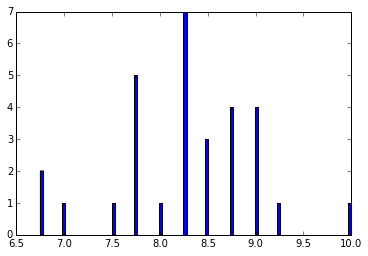

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(speeds,bins = 100)

In [5]:
print np.mean(speeds)
print np.max(speeds)

8.275
10.0


* Analyse accuracy

In [23]:
time_gap = []
for i, GPS_point in enumerate(GPS_points[1:]):
    u = GPS_point.dt - GPS_points[i].dt
    time_gap.append(u.seconds)

In [24]:
time_gap

[0,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1]

In [26]:
# Simple stats
from scipy import stats

print 'Mean: ' + str(np.mean(time_gap))
#print stats.mode(time_gap,axis=None)
print 'Min: ' + str(np.min(time_gap))
print 'Max: ' + str(np.max(time_gap))

Mean: 0.965517241379
Min: 0
Max: 2


* Data preprocessing

In [8]:
# Convert lat/lon to easting/northing
Es = []
Ns = []
for i in range(0,len(lats)):
    E,N = WGS84toOSGB36(lats[i], lons[i])
    Es.append(E)
    Ns.append(N)

In [9]:
# Convert speeds to meters/second
if speed_unit == 'm_per_hour':
    speeds = [0.44704*speed for speed in speeds]
if speed_unit == 'km_per_hour':
    speeds = [0.277777778*speed for speed in speeds]

In [10]:
# Convert readings to GPS point class objects
GPS_points = []
for idx in range(0,len(Es)):
    GPS_points.append(Point(Es[idx],Ns[idx],speeds[idx],bearings[idx],datetimes[idx]))

* Import underlyng street network

In [11]:
# Network based
import igraph as ig
tobys_dir = 'C:/Users/KiraPc/Dropbox/topic modelling/data/itn directed network from toby/'
camden_network = ig.load(tobys_dir + 'camden_buff100_routing.graphml')

In [12]:
from cPickle import load, dump
with open(tobys_dir + 'camden_buff100_node_positions.pkl','r') as infile:
    node_positions = load(infile)
with open(tobys_dir + 'camden_buff100_edge_polylines_kira.pkl','r') as infile:
    edge_polylines = load(infile)

In [13]:
street_network = [camden_network,node_positions,edge_polylines]

* Plot journey

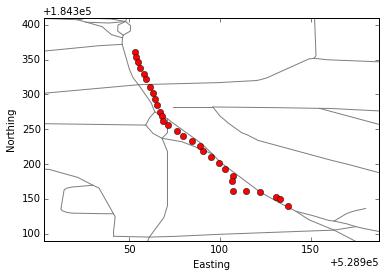

In [14]:
%matplotlib inline
# Plot exemplary journey on the network
for segment in edge_polylines.values():
    plt.plot(segment[:,0],segment[:,1],'grey')
for point in GPS_points:
    plt.plot(point.e, point.n, 'ro')
#plt.plot(Es[90:120], Ns[90:120], 'ro-')
plt.xlim(min(Es)-50, max(Es)+50)
plt.ylim(min(Ns)-50, max(Ns)+50)
plt.xlabel('Easting')
plt.ylabel('Northing')

* Pick one point for initial analysis

In [15]:
GPS_first = GPS_points[0]

* Initalize particles

In [16]:
initial_measurement_error = 5

In [17]:
# Along the street network
S_first,itern_no = initialize_particles_network(100,GPS_first,initial_measurement_error,street_network)

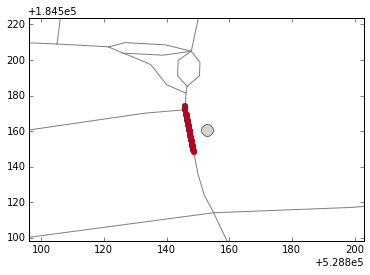

In [18]:
plot_particles_network(S_first,GPS_first,street_network,idx=-1)

* Update particles

In [19]:
measurement_error = 10
transition_error = 10

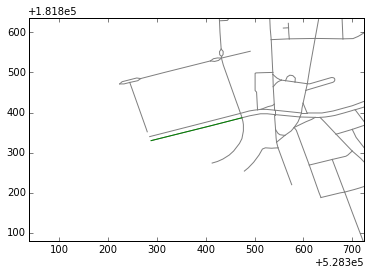

In [13]:
segment_fid = 'osgb4000000030099857'
visualise_segment(segment_fid, street_network)

0
0:00:00
1
0:00:00
2
0:00:01
3
0:00:01
4
0:00:02
5
0:00:00
6
0:00:02
7
0:00:01
8
0:00:00
9
0:00:02
10
0:00:00
11
0:00:02
12
0:00:01
13
0:00:01
14
0:00:00
15
0:00:02
16
0:00:01
17
0:00:01
18
0:00:01
19
0:00:00
20
0:00:01
21
0:00:02
22
0:00:00
23
0:00:02
24
0:00:01
25
0:00:01
26
0:00:01
27
0:00:00
28
0:00:01
29
0:00:01


C:\Users\KiraPc\Anaconda\lib\site-packages\matplotlib\pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


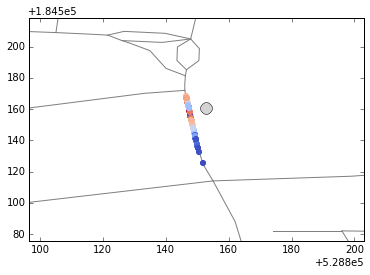

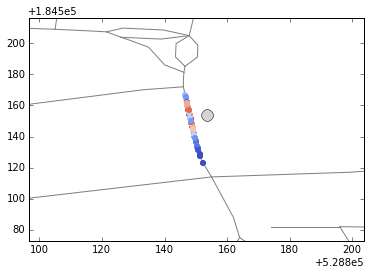

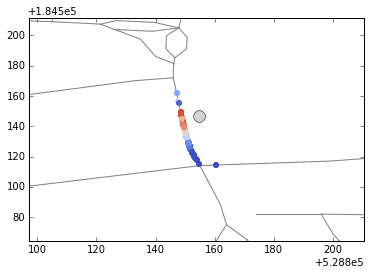

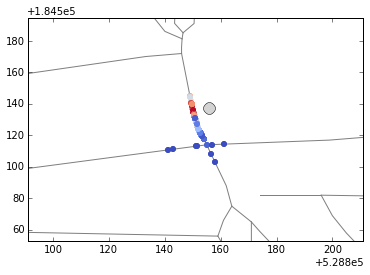

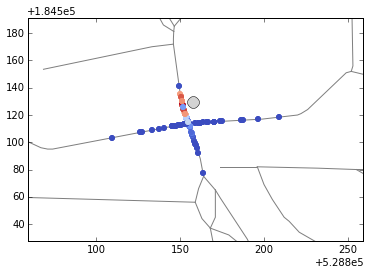

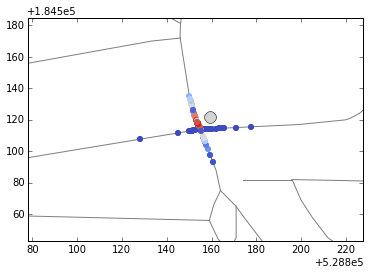

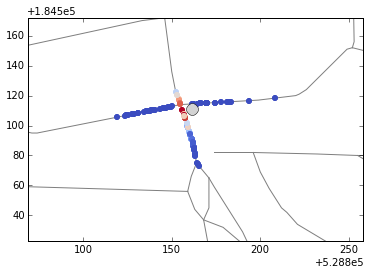

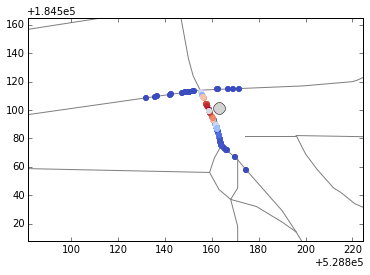

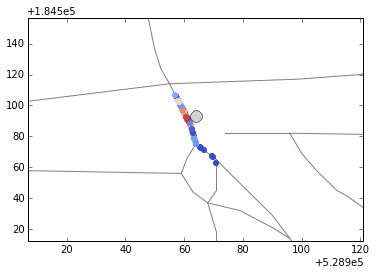

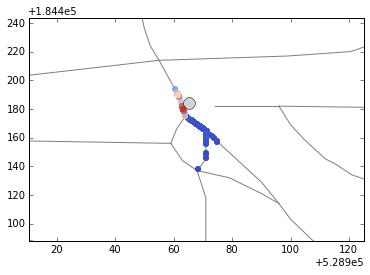

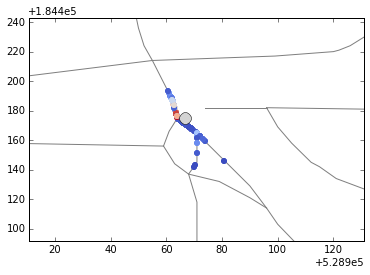

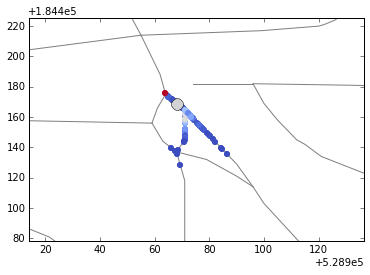

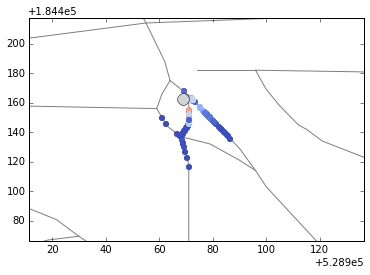

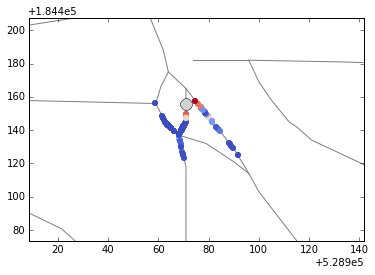

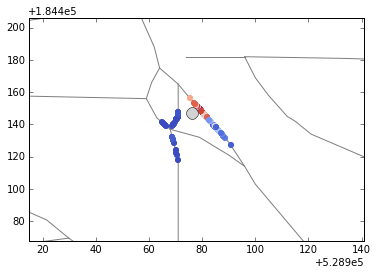

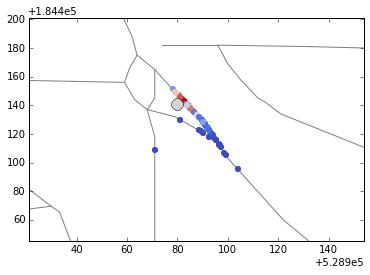

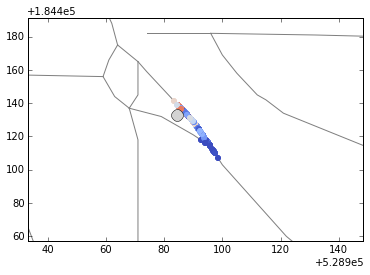

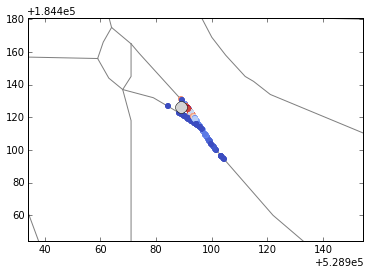

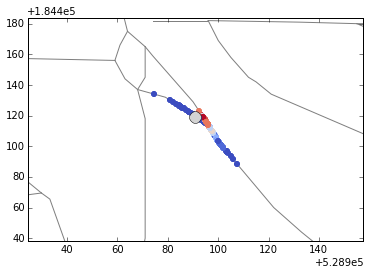

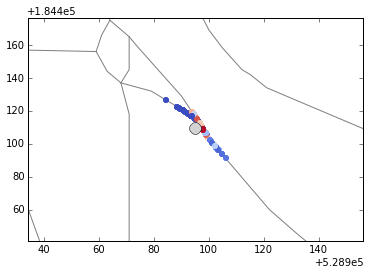

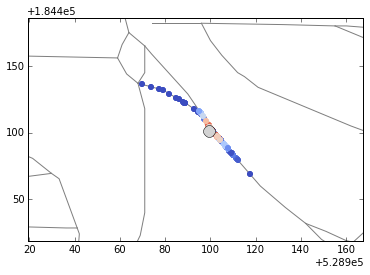

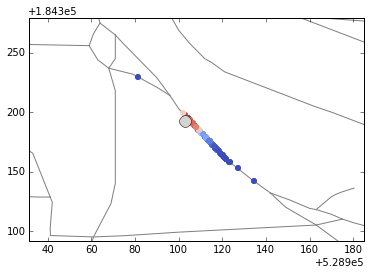

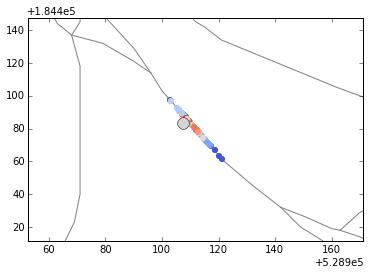

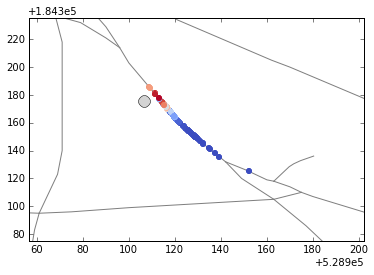

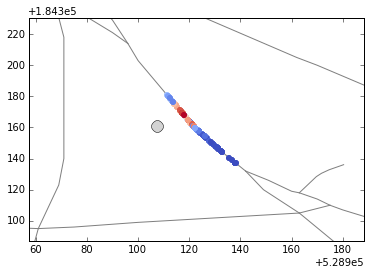

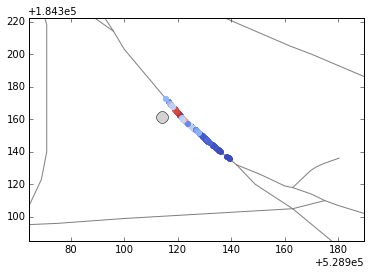

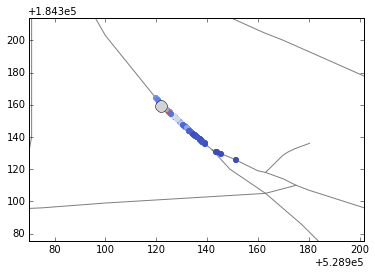

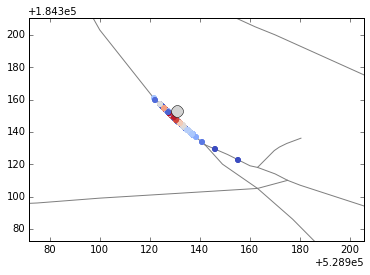

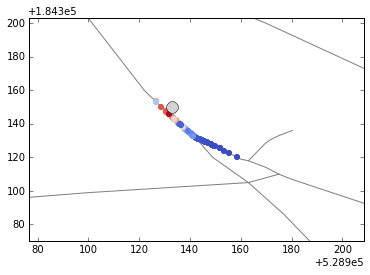

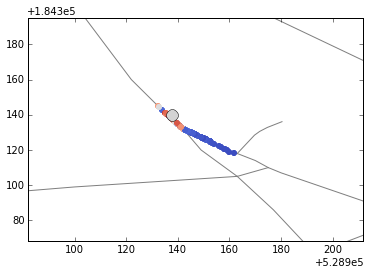

In [20]:
import datetime
GPS_point_old = GPS_first
S = S_first

for i,GPS_point in enumerate(GPS_points):
    u = GPS_point.dt - GPS_point_old.dt
    #if time_unit == 'min': # allow up to 59 secs more as 1:59 and 1:00 minutes would be represented in the same way
    #    secs_extra = random.choice(range(0,60))
    #    u = u + datetime.timedelta(0,secs_extra)
        
    print i
    print u

    S, xbase, mean_displacement = particle_filter_network(S,u,GPS_point,street_network,measurement_error,transition_error)    
    plot_particles_network(S,GPS_point,street_network,-1)

    GPS_point_old = GPS_point

* Recover particle history

In [21]:
# Aggregate possible histories (by summing weights of particles) 
histories = []  # dict that stores weight of each possible history of travel
weights = []
for particle, weight in S:
    history = particle.h
    if history in histories:
        idx = histories.index(history)
        weight_old = weights[idx]
        weights[idx] = weight_old + weight
    else:
        histories.append(history)
        weights.append(weight)

* Plot the most likely trajectory

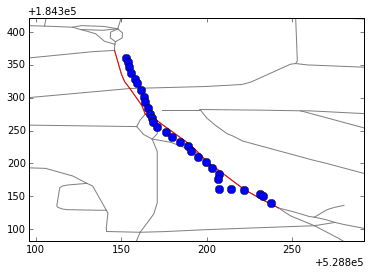

In [22]:
history = histories[np.argmax(weights)]

# Background
for segment in edge_polylines.values():
    coords = zip(*segment)        # zip + * unzips a list!
    plt.plot(coords[0],coords[1], 'grey')

# History
minx = 10000000
miny = 10000000
maxx=0
maxy=0
for segment in history:
    xs = edge_polylines[segment][:,0]
    ys = edge_polylines[segment][:,1]
    # Store min values
    if min(xs)<minx:
        minx = min(xs)
    if min(ys)<miny:
        miny = min(ys)
    if max(xs)>maxx:
        maxx = max(xs)
    if max(ys)>maxy:
        maxy = max(ys)
        
    plt.plot(xs,ys, 'red')

plt.xlim(minx-50, maxx+50)
plt.ylim(miny-50, maxy+50)

# GPS trace
for point in GPS_points:
    plt.plot(point.e, point.n, color ='blue', marker = 'o', markersize = 8)